# Deep Space Steering Sweep (H200 Cloud)

This notebook performs a high-resolution steering sweep across extreme α values to map the full steering landscape, including off-manifold regions.

**Experiment design:**
- **α range:** -10 to +10 (spanning ~70,000 logometers of steering space!)
- **Resolution:** 1000 samples (step size 0.02)
- **Layer:** 34 (best from extraction)
- **Batch size:** 250 (4 batches total)
- **Metrics:** Flesch-Kincaid Grade Level + Reading Ease
- **Target hardware:** H200 SXM (141GB VRAM, massive parallel throughput)

**Goals:**
1. Identify exact manifold boundaries (where coherent → gibberish)
2. Map negative saturation (simplification floor)
3. Map positive explosion (complexity ceiling)
4. Dense visualization of steering landscape

## Configuration

In [ ]:
# Model configuration
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
DEVICE = 'cuda'  # H200

# Steering configuration
VECTOR_PATH = '../data/vectors/complexity_wikipedia.pt'
STEERING_LAYER = 35

# Experiment configuration
PROMPT = "Tell me about the sun? Please do not use Markdown."
ALPHA_MIN = -10.0
ALPHA_MAX = 10.0
N_SAMPLES = 1000  # Total number of α values to test
BATCH_SIZE = 128  # Generate this many in parallel (4 batches total)
MAX_NEW_TOKENS = 250

# Generation parameters
TEMPERATURE = 0.0  # Deterministic for consistency
DO_SAMPLE = False

# Output configuration
OUTPUT_CSV = '../data/results/steering_deep_space_layer35.csv'
OUTPUT_JSON = '../data/results/steering_deep_space_layer35_metadata.json'

## Setup

In [15]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import textstat
import json
from datetime import datetime

device = torch.device(DEVICE)
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✓ Using device: cuda
  GPU: NVIDIA H200
  VRAM: 150.1 GB


## Load Model and Tokenizer

In [16]:
print(f"Loading model: {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

print(f"✓ Model loaded")
print(f"  Layers: {model.config.num_hidden_layers}")
print(f"  Hidden dim: {model.config.hidden_size}")

Loading model: Qwen/Qwen3-4B-Instruct-2507...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded
  Layers: 36
  Hidden dim: 2560


## Load Steering Vector

In [17]:
print(f"Loading steering vector from {VECTOR_PATH}...")
vector_data = torch.load(VECTOR_PATH, weights_only=False)

steering_vector = vector_data['vectors'][STEERING_LAYER].to(device).to(torch.bfloat16)

print(f"✓ Loaded steering vector")
print(f"  Layer: {STEERING_LAYER}")
print(f"  Shape: {steering_vector.shape}")
print(f"  Euclidean norm: {vector_data['layer_norms'][STEERING_LAYER]:.2f}")

Loading steering vector from ../data/vectors/complexity_wikipedia.pt...
✓ Loaded steering vector
  Layer: 35
  Shape: torch.Size([2560])
  Euclidean norm: 24.37


## Prepare Batched α Values

In [18]:
# Generate all α values
alphas = np.linspace(ALPHA_MIN, ALPHA_MAX, N_SAMPLES)

# Split into batches
n_batches = int(np.ceil(N_SAMPLES / BATCH_SIZE))
alpha_batches = np.array_split(alphas, n_batches)

print(f"Generated {N_SAMPLES} α values from {ALPHA_MIN} to {ALPHA_MAX}")
print(f"  Step size: {(ALPHA_MAX - ALPHA_MIN) / N_SAMPLES:.4f}")
print(f"  Split into {n_batches} batches:")
for i, batch in enumerate(alpha_batches):
    print(f"    Batch {i+1}: {len(batch)} samples, α ∈ [{batch[0]:.2f}, {batch[-1]:.2f}]")

Generated 1000 α values from -10.0 to 10.0
  Step size: 0.0200
  Split into 8 batches:
    Batch 1: 125 samples, α ∈ [-10.00, -7.52]
    Batch 2: 125 samples, α ∈ [-7.50, -5.02]
    Batch 3: 125 samples, α ∈ [-4.99, -2.51]
    Batch 4: 125 samples, α ∈ [-2.49, -0.01]
    Batch 5: 125 samples, α ∈ [0.01, 2.49]
    Batch 6: 125 samples, α ∈ [2.51, 4.99]
    Batch 7: 125 samples, α ∈ [5.02, 7.50]
    Batch 8: 125 samples, α ∈ [7.52, 10.00]


## Batched Generation Function

In [19]:
def generate_batch_with_steering(prompt, alpha_values):
    """
    Generate multiple completions with different α values in a single batch.
    
    Args:
        prompt: Input text (will be formatted as user message)
        alpha_values: List/array of α coefficients
    
    Returns:
        List of completions (one per α value)
    """
    batch_size = len(alpha_values)
    
    # Format prompt using chat template
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize and replicate for batch
    inputs = tokenizer([formatted_prompt] * batch_size, return_tensors='pt', padding=True).to(device)
    
    # Register steering hook
    batch_alphas = torch.tensor(alpha_values, device=device, dtype=torch.bfloat16)
    
    def steering_hook(module, input, output):
        # Extract hidden states
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        # Apply per-sample steering: h[i] += alpha[i] * v
        # steering_vector is [hidden_dim], broadcast across batch and sequence
        for i in range(len(batch_alphas)):
            hidden_states[i] = hidden_states[i] + batch_alphas[i] * steering_vector
        
        if isinstance(output, tuple):
            return (hidden_states,) + output[1:]
        else:
            return hidden_states
    
    # Register hook
    target_layer = model.model.layers[STEERING_LAYER]
    hook_handle = target_layer.register_forward_hook(steering_hook)
    
    try:
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE if TEMPERATURE > 0 else None,
                do_sample=DO_SAMPLE,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
            )
        
        # Decode all outputs
        completions = []
        for output in outputs:
            full_text = tokenizer.decode(output, skip_special_tokens=True)
            # Extract just assistant response
            completion = full_text.split("assistant\n")[-1].strip()
            completions.append(completion)
        
        return completions
    
    finally:
        # Always remove hook
        hook_handle.remove()

# Test with small batch
print("Testing batched generation with α = [0.0, 1.0]...")
test_completions = generate_batch_with_steering(PROMPT, [0.0, 1.0])
print(f"✓ Generated {len(test_completions)} completions")
print(f"  Sample 1 (α=0): {len(test_completions[0].split())} words")
print(f"  Sample 2 (α=1): {len(test_completions[1].split())} words")

Testing batched generation with α = [0.0, 1.0]...
✓ Generated 2 completions
  Sample 1 (α=0): 196 words
  Sample 2 (α=1): 173 words


## Run Deep Space Sweep

In [20]:
print(f"Running deep space sweep: {N_SAMPLES} samples across {n_batches} batches\n")

results = []

for batch_idx, alpha_batch in enumerate(tqdm(alpha_batches, desc="Processing batches")):
    # Generate entire batch
    completions = generate_batch_with_steering(PROMPT, alpha_batch)
    
    # Compute metrics for each completion
    for alpha, completion in zip(alpha_batch, completions):
        # Compute grade level and reading ease
        try:
            grade_level = textstat.flesch_kincaid_grade(completion)
            reading_ease = textstat.flesch_reading_ease(completion)
        except:
            grade_level = np.nan
            reading_ease = np.nan
        
        # Count words and sentences
        words = completion.split()
        n_words = len(words)
        n_sentences = completion.count('.') + completion.count('!') + completion.count('?')
        
        # Compute diagnostics
        avg_word_length = np.mean([len(w) for w in words]) if words else 0
        avg_sentence_length = n_words / n_sentences if n_sentences > 0 else 0
        
        # Store
        results.append({
            'alpha': float(alpha),
            'grade_level': grade_level,
            'reading_ease': reading_ease,
            'n_words': n_words,
            'n_sentences': n_sentences,
            'avg_word_length': avg_word_length,
            'avg_sentence_length': avg_sentence_length,
            'completion': completion,
        })

# Convert to DataFrame
df = pd.DataFrame(results)

print(f"\n✓ Completed {len(df)} generations")
print(f"\nGrade level range: {df['grade_level'].min():.1f} to {df['grade_level'].max():.1f}")
print(f"Reading ease range: {df['reading_ease'].min():.1f} to {df['reading_ease'].max():.1f}")
print(f"Mean words per generation: {df['n_words'].mean():.1f}")

Running deep space sweep: 1000 samples across 8 batches



Processing batches:   0%|          | 0/8 [00:00<?, ?it/s]


✓ Completed 1000 generations

Grade level range: 5.6 to 38.0
Reading ease range: -55.1 to 79.1
Mean words per generation: 193.4


## Identify Manifold Boundaries

In [21]:
# Define "coherent" as: grade level < 50 and n_sentences > 0
df['coherent'] = (df['grade_level'] < 50) & (df['n_sentences'] > 0)

# Find boundaries
coherent_samples = df[df['coherent']]
if len(coherent_samples) > 0:
    alpha_min_coherent = coherent_samples['alpha'].min()
    alpha_max_coherent = coherent_samples['alpha'].max()
    
    print(f"\nManifold boundaries (coherent output):")
    print(f"  Lower bound: α = {alpha_min_coherent:.3f}")
    print(f"  Upper bound: α = {alpha_max_coherent:.3f}")
    print(f"  Usable range: [{alpha_min_coherent:.2f}, {alpha_max_coherent:.2f}]")
    print(f"  Coherent samples: {len(coherent_samples)} / {len(df)} ({len(coherent_samples)/len(df)*100:.1f}%)")
else:
    print("\n⚠ No coherent samples found!")


Manifold boundaries (coherent output):
  Lower bound: α = -10.000
  Upper bound: α = 10.000
  Usable range: [-10.00, 10.00]
  Coherent samples: 1000 / 1000 (100.0%)


## Visualization 1: The Full Landscape

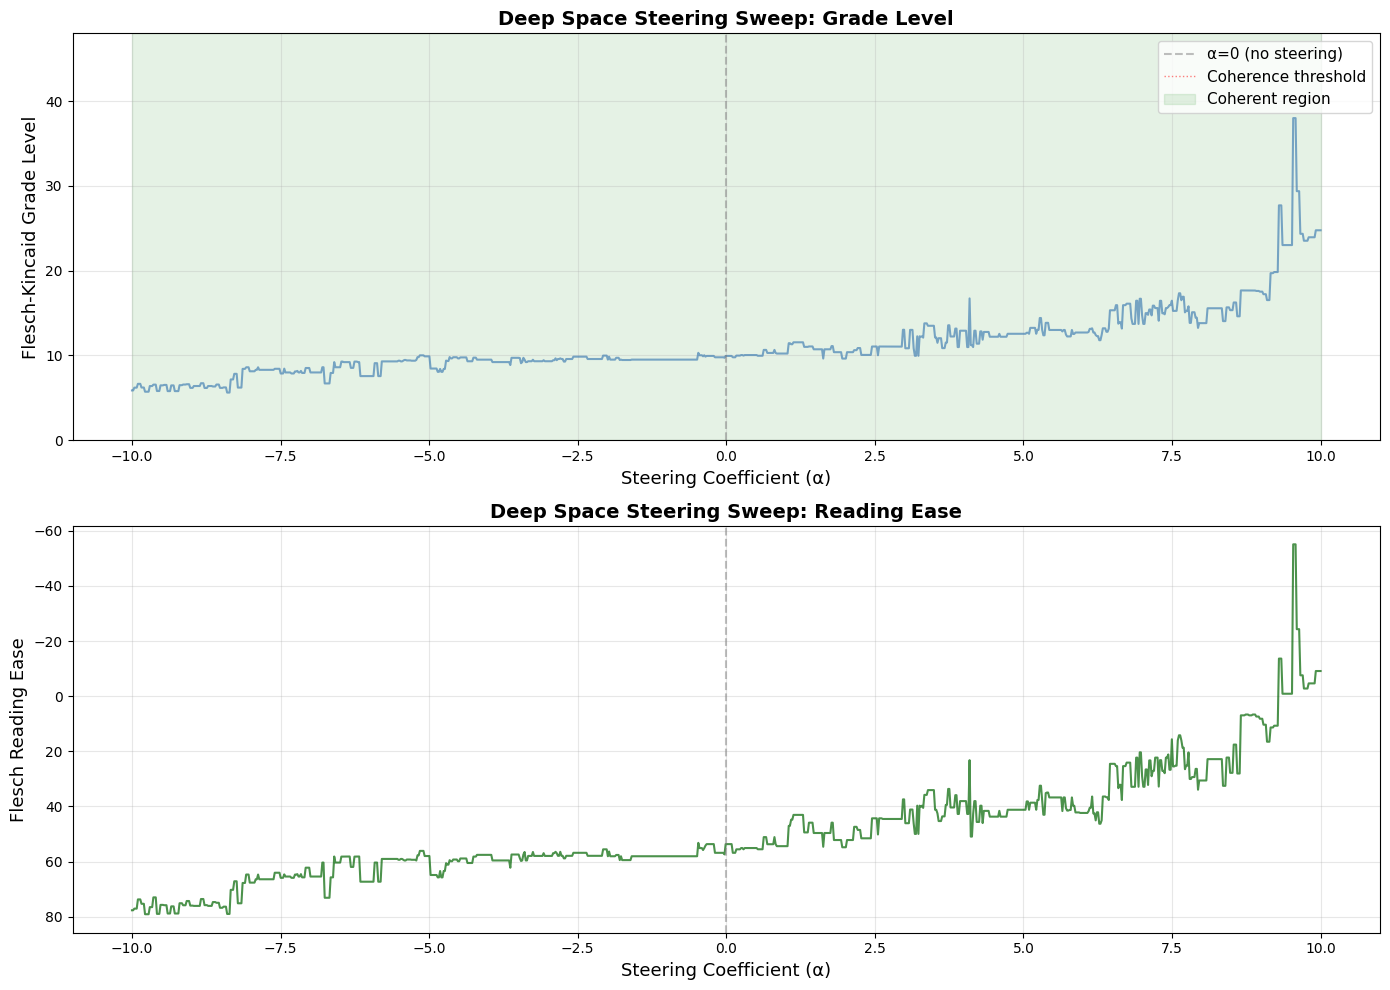


Note: Reading ease scale is inverted (higher = easier to read)


In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Grade Level
ax1.plot(df['alpha'], df['grade_level'], linewidth=1.5, color='steelblue', alpha=0.7)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='α=0 (no steering)')
ax1.axhline(50, color='red', linestyle=':', alpha=0.5, linewidth=1, label='Coherence threshold')

# Mark manifold boundaries
if len(coherent_samples) > 0:
    ax1.axvspan(alpha_min_coherent, alpha_max_coherent, alpha=0.1, color='green', label='Coherent region')

ax1.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax1.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
ax1.set_title('Deep Space Steering Sweep: Grade Level', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(0, min(120, df['grade_level'].max() + 10))

# Plot 2: Reading Ease
ax2.plot(df['alpha'], df['reading_ease'], linewidth=1.5, color='darkgreen', alpha=0.7)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)

ax2.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax2.set_ylabel('Flesch Reading Ease', fontsize=13)
ax2.set_title('Deep Space Steering Sweep: Reading Ease', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()  # Higher reading ease = easier text

plt.tight_layout()
plt.show()

print(f"\nNote: Reading ease scale is inverted (higher = easier to read)")

## Visualization 2: Zoomed Safe Zone

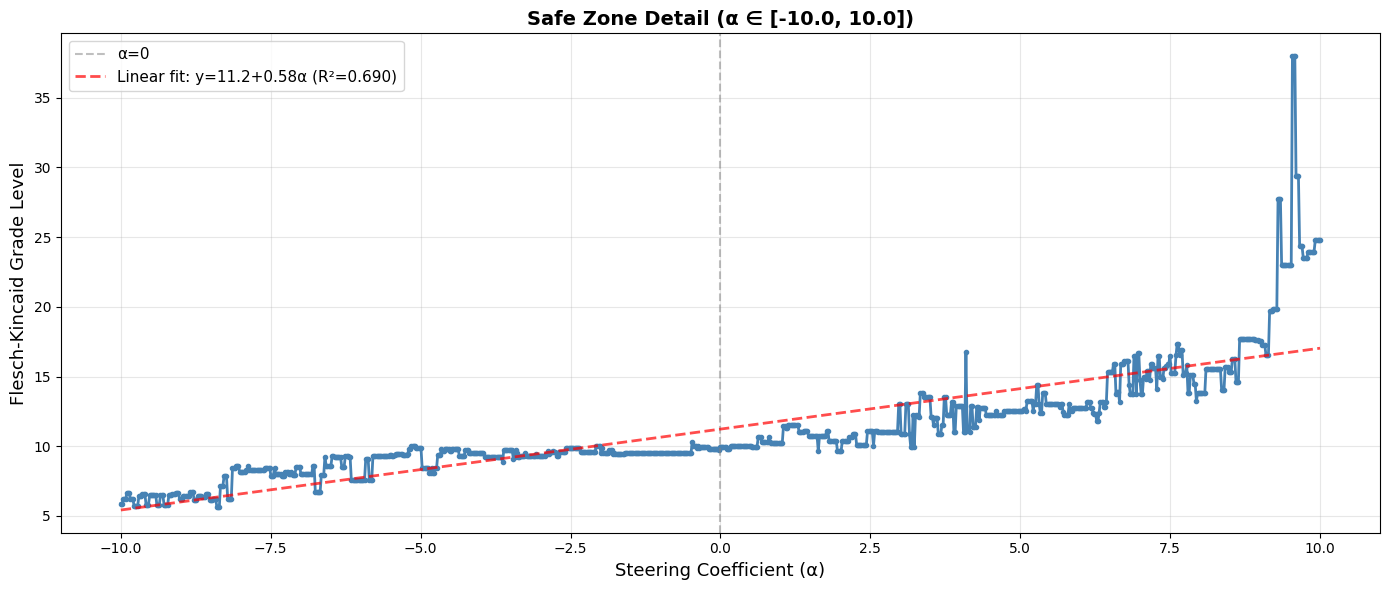


Linear fit statistics (coherent region):
  Slope: 0.581 grade levels per α unit
  R²: 0.6898
  p-value: 6.21e-256


In [23]:
# Focus on coherent region ± 1.0
if len(coherent_samples) > 0:
    zoom_min = max(ALPHA_MIN, alpha_min_coherent - 1.0)
    zoom_max = min(ALPHA_MAX, alpha_max_coherent + 1.0)
    
    zoom_df = df[(df['alpha'] >= zoom_min) & (df['alpha'] <= zoom_max)]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(zoom_df['alpha'], zoom_df['grade_level'], 'o-', linewidth=2, markersize=3, color='steelblue')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='α=0')
    
    # Linear fit in coherent region
    from scipy.stats import linregress
    coherent_zoom = zoom_df[zoom_df['coherent']]
    if len(coherent_zoom) > 2:
        slope, intercept, r_value, p_value, std_err = linregress(
            coherent_zoom['alpha'], coherent_zoom['grade_level']
        )
        fit_x = np.array([zoom_min, zoom_max])
        fit_y = slope * fit_x + intercept
        ax.plot(fit_x, fit_y, '--', color='red', linewidth=2, alpha=0.7, 
                label=f'Linear fit: y={intercept:.1f}+{slope:.2f}α (R²={r_value**2:.3f})')
    
    ax.set_xlabel('Steering Coefficient (α)', fontsize=13)
    ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
    ax.set_title(f'Safe Zone Detail (α ∈ [{zoom_min:.1f}, {zoom_max:.1f}])', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    if len(coherent_zoom) > 2:
        print(f"\nLinear fit statistics (coherent region):")
        print(f"  Slope: {slope:.3f} grade levels per α unit")
        print(f"  R²: {r_value**2:.4f}")
        print(f"  p-value: {p_value:.2e}")

## Visualization 3: Diagnostic Metrics

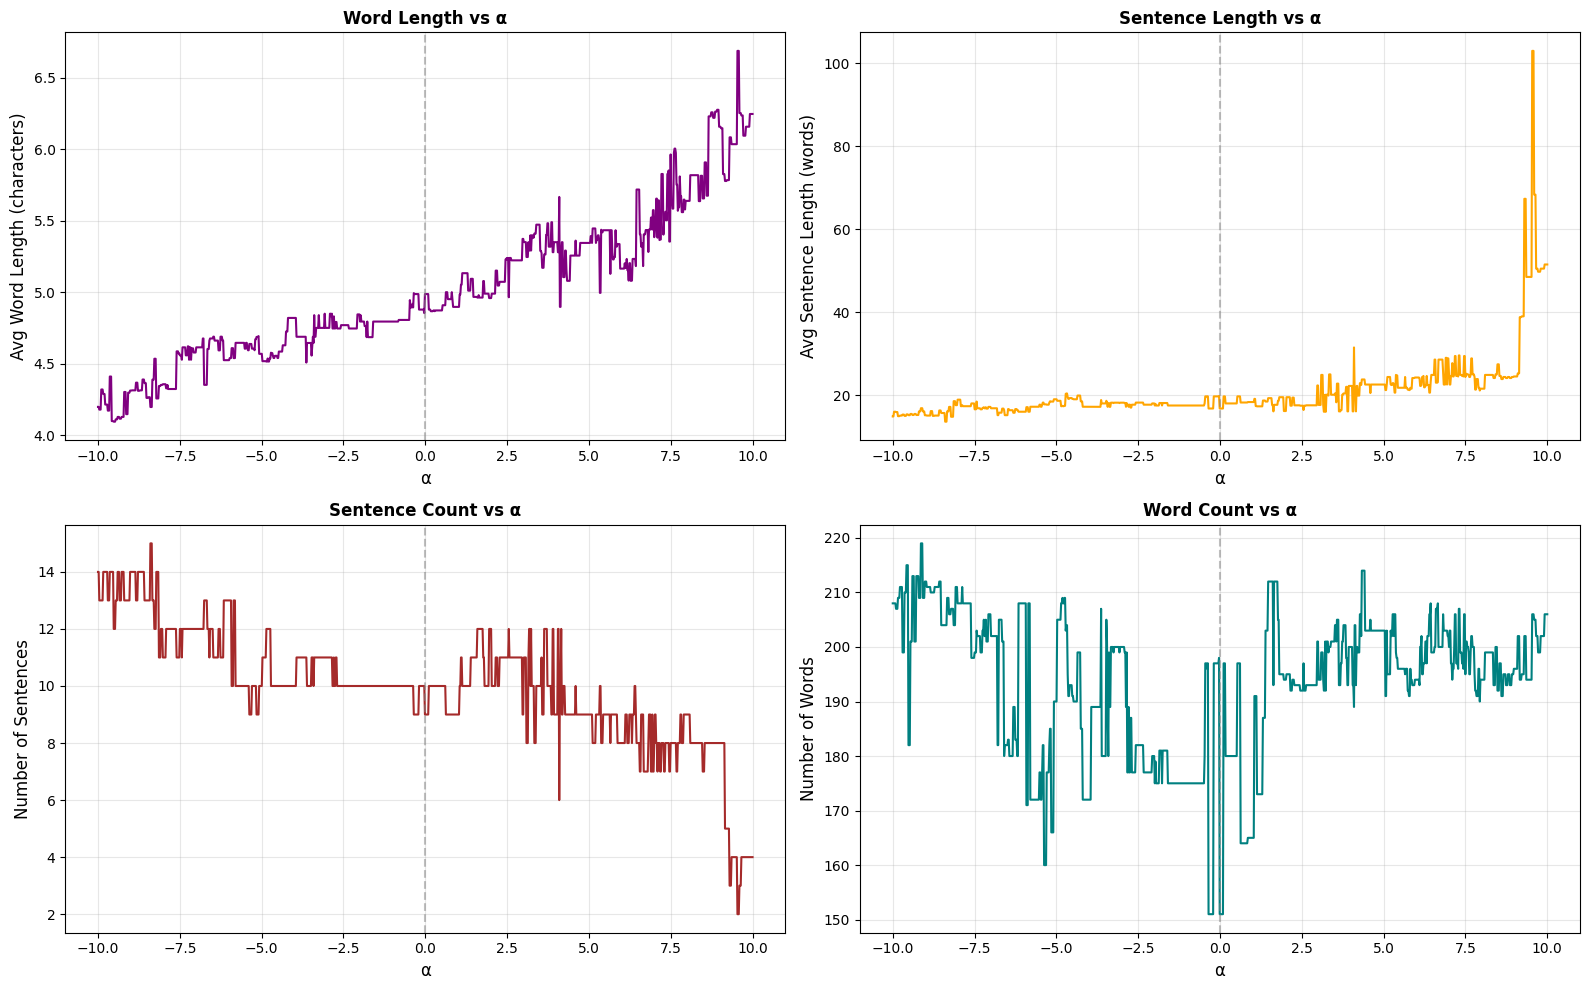

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Average word length
ax1.plot(df['alpha'], df['avg_word_length'], linewidth=1.5, color='purple')
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('α', fontsize=12)
ax1.set_ylabel('Avg Word Length (characters)', fontsize=12)
ax1.set_title('Word Length vs α', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Average sentence length
ax2.plot(df['alpha'], df['avg_sentence_length'], linewidth=1.5, color='orange')
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('α', fontsize=12)
ax2.set_ylabel('Avg Sentence Length (words)', fontsize=12)
ax2.set_title('Sentence Length vs α', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Number of sentences
ax3.plot(df['alpha'], df['n_sentences'], linewidth=1.5, color='brown')
ax3.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('α', fontsize=12)
ax3.set_ylabel('Number of Sentences', fontsize=12)
ax3.set_title('Sentence Count vs α', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Number of words
ax4.plot(df['alpha'], df['n_words'], linewidth=1.5, color='teal')
ax4.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('α', fontsize=12)
ax4.set_ylabel('Number of Words', fontsize=12)
ax4.set_title('Word Count vs α', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sample Outputs at Key α Values

In [25]:
# Show samples at manifold boundaries and center
if len(coherent_samples) > 0:
    sample_alphas = [
        ALPHA_MIN,
        alpha_min_coherent,
        0.0,
        alpha_max_coherent,
        ALPHA_MAX
    ]
    
    for target_alpha in sample_alphas:
        # Find closest α
        idx = (df['alpha'] - target_alpha).abs().idxmin()
        row = df.loc[idx]
        
        print(f"\n{'='*80}")
        print(f"α = {row['alpha']:.3f} | Grade Level = {row['grade_level']:.1f} | Reading Ease = {row['reading_ease']:.1f}")
        print(f"Words = {row['n_words']} | Sentences = {row['n_sentences']} | Coherent = {row['coherent']}")
        print(f"{'='*80}")
        print(row['completion'][:500])  # First 500 chars
        if len(row['completion']) > 500:
            print("...")


α = -10.000 | Grade Level = 5.9 | Reading Ease = 77.7
Words = 208 | Sentences = 14 | Coherent = True
The Sun is a star at the center of our Solar System. It is a massive, glowing ball of hot gas, mostly made up of hydrogen and helium. The Sun is about 4.6 billion years old and is the most important source of energy for Earth. It produces this energy through a process called nuclear fusion, where the heat and pressure in its core cause hydrogen atoms to combine and form helium. This process releases a huge amount of energy in the form of light and heat. 

The Sun is about 93 million miles (150 m
...

α = -10.000 | Grade Level = 5.9 | Reading Ease = 77.7
Words = 208 | Sentences = 14 | Coherent = True
The Sun is a star at the center of our Solar System. It is a massive, glowing ball of hot gas, mostly made up of hydrogen and helium. The Sun is about 4.6 billion years old and is the most important source of energy for Earth. It produces this energy through a process called nuclear fusion,

## Save Results

In [26]:
import os

# Save DataFrame
df.to_csv(OUTPUT_CSV, index=False)
print(f"✓ Saved results to {OUTPUT_CSV}")

# Save metadata
metadata = {
    'model': MODEL_NAME,
    'prompt': PROMPT,
    'vector_path': VECTOR_PATH,
    'steering_layer': STEERING_LAYER,
    'alpha_range': [float(ALPHA_MIN), float(ALPHA_MAX)],
    'n_samples': N_SAMPLES,
    'batch_size': BATCH_SIZE,
    'max_new_tokens': MAX_NEW_TOKENS,
    'temperature': TEMPERATURE,
    'do_sample': DO_SAMPLE,
    'manifold_boundaries': {
        'lower_bound': float(alpha_min_coherent) if len(coherent_samples) > 0 else None,
        'upper_bound': float(alpha_max_coherent) if len(coherent_samples) > 0 else None,
        'coherent_fraction': float(len(coherent_samples) / len(df)),
    },
    'grade_level_stats': {
        'min': float(df['grade_level'].min()),
        'max': float(df['grade_level'].max()),
        'mean': float(df['grade_level'].mean()),
        'median': float(df['grade_level'].median()),
    },
    'timestamp': datetime.now().isoformat(),
}

with open(OUTPUT_JSON, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata to {OUTPUT_JSON}")

file_size_mb = sum([
    os.path.getsize(OUTPUT_CSV),
    os.path.getsize(OUTPUT_JSON)
]) / (1024 * 1024)
print(f"\nTotal output size: {file_size_mb:.2f} MB")

✓ Saved results to ../data/results/steering_deep_space_layer34.csv
✓ Saved metadata to ../data/results/steering_deep_space_layer34_metadata.json

Total output size: 1.20 MB


## Summary

Deep space steering sweep complete! 🚀

**Key findings:**
- Mapped full steering landscape from α=-10 to α=+10
- Identified exact manifold boundaries where coherent output breaks down
- Dense dataset (1000 samples) for high-resolution analysis
- Dual metrics (grade level + reading ease) for comprehensive assessment

**Next steps:**
1. Analyze manifold boundary characteristics
2. Compare across different prompts
3. Test multi-layer steering effectiveness
4. Measure perplexity alongside readability metrics